# 从零开始创建属于你的大语言模型



## 一、从零开始构建演示用模型

本演示模型使用 decoder-only 架构，在 6 个句子上进行预训练，主要用于展示大语言模型背后的原理。

主要参考文章：<https://medium.com/@sntaus/building-a-mini-gpt-like-language-model-from-scratch-27257bf5c145>





模型架构如图：

这个架构是 [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master)的架构（和GPT2相同），但和上述文章中的架构不太相同（主要diff 在前馈连接处），我们修改代码为如下架构。（除了Dropout层没有配置）。

![](https://raw.githubusercontent.com/TatevKaren/BabyGPT-Build_GPT_From_Scratch/3001374a3c7df5f63194028ff7f3933419a29dfa/GPT%20Series/Images/Full_GPT_architecture.png)

### 1.1 依赖

首先安装必要的依赖：

In [ ]:
import torch # 依赖 PyTorch 库
import torch.nn as nn # 使用 PyTorch 中的 NN 库（Neural network 神经网络）
import torch.optim as optim # 训练优化器
import pprint # Pretty Print 库，用于更好的打印输出

### 1.2 数据准备

接下来，我们需要准备训练用的无监督文本以及词汇表。我们首先定义几个术语：

- Token（标记）：标记是指模型可以解释为一个唯一嵌入向量的单个“单词”。标记并不一定和自然语言的单词相同，但是在本示例中，我们将一个单词对应一个标记。
- Vocabulary（词汇表）：所有 Token 组成的列表。如果输出的词汇不在词汇表中，模型将不会理解该标记。
- Text sequence（文本序列）：文本序列是顺序排列的 Token 的列表。大语言模型的输入叫输入序列（比如是 `hello`），输出是输出序列（如 `world<end>`）。
- Vocabulary（词汇表索引）：词汇表中特定 Token 的唯一索引的 ID，也可以表述为独热（One-hot）编码。假如词汇表大小为6， `hello` 是词汇表的第 2 个单词，那么其索引为 1，其独热编码为 `[0, 1, 0, 0, 0, 0]`


定义本模型的训练数据和词汇表：

In [ ]:
# 输出：
#   - training_datag：预训练数据，格式为 {<input>: <output>}
#   - data_words: 预训练数据中所有 input 序列。
#   - target_words: 预训练数据中所有 output 序列。
#   - vocabulary_words：词汇表
#   - word_to_ix：token 转换为词汇表的 index 的字典
#   - ix_to_word: index 转换为 token 的字典
def get_data_and_vocab():
    # 定义预训练数据，由 6 个句子组成。
    # 在真实的模型中，预训练数据是 <text> 然后在训练过程中，进行随机切分，拆分为 <input>: <output>
    training_data = {
        "how are you": "i am fine <end>",
        "who is john": "a nice person <end>",
        "who is nice": "john <end>",
        "where is john": "at home <end>",
        "how is john": "i dont know <end>",
        "who are you": "mini gpt model <end>"
    }

    # 将 input 和 output 序列写入列表。
    data_words = [k for k, _ in training_data.items()]
    target_words = [v for _, v in training_data.items()]

    # 把所有的词汇提取出来构建词汇表
    vocabulary_words = sorted(list(set([element.lower() for nestedlist in [x.split(" ") for x in data_words] for element in nestedlist] + [element.lower() for nestedlist in [x.split(" ") for x in target_words] for element in nestedlist])))

    # 保证词汇表中有  <end> Token 用来标记句子结束，并在词汇表中增加 <pad> Token作为补齐用的标记。
    vocabulary_words.remove("<end>")
    vocabulary_words.append("<end>")
    vocabulary_words.insert(0, "<pad>")

    # 创建词汇到 index 以及 index 到词汇的字典。
    word_to_ix = {vocabulary_words[k].lower(): k for k in range(len(vocabulary_words))}
    ix_to_word = {v: k for k, v in word_to_ix.items()}

    # 全部返回
    return training_data, data_words, target_words, vocabulary_words, word_to_ix, ix_to_word


training_data, data_words, target_words, vocabulary_words, word_to_ix, ix_to_word = get_data_and_vocab()
word_to_ix

{'<pad>': 0,
 'a': 1,
 'am': 2,
 'are': 3,
 'at': 4,
 'dont': 5,
 'fine': 6,
 'gpt': 7,
 'home': 8,
 'how': 9,
 'i': 10,
 'is': 11,
 'john': 12,
 'know': 13,
 'mini': 14,
 'model': 15,
 'nice': 16,
 'person': 17,
 'where': 18,
 'who': 19,
 'you': 20,
 '<end>': 21}

### 1.3 文本序列转换为张量

我们需要定义两个辅助函数，可以将文本序列转换为张量以及从张量转换为文本序列，用于将文本转换为模型输入以及将模型输出恢复为文本。

张量是 Torch 中的概念，数学上就是矩阵。大语言模型的输入、输出以及计算过程，全部都是张量计算。

文本序列转换为张量的过程：

1. 文本序列：`how are you`
2. 转换为词汇表索引：`[9, 3, 20]` （这一步骤在 LLM 中又称为 tokenize，因为现代 LLM 的词汇表极大，所以此处需要有专门的分词器进行高效的分词）
3. 转换为嵌入向量，每个 Token 都有一个唯一的嵌入向量。嵌入向量的维度是固定的，简单的理解就是大的稀疏的 One-hot 编码转换为固定长度的稠密向量。嵌入转换使用 `nn.Embedding` 进行。


In [ ]:
# 将文本序列的列表，转换为词汇表索引的向量组成的二维矩阵（张量）。同时使用 padding，将所有的向量补齐到相同长度。
# 这是因为计算的时候，一批一维向量要想形成二位矩阵，需要长度相同。
def words_to_tensor(seq_batch, device=None):
    index_batch = []

    # 遍历文本序列的列表中的每个文本序列（seq）
    for seq in seq_batch:
        word_list = seq.lower().split(" ")
        # 使用空格分词，然后使用 word_to_ix 词典转换为词汇表索引向量。
        indices = [word_to_ix[word] for word in word_list if word in word_to_ix]
        t = torch.tensor(indices)
        # torch 里不同的设备（cpu、gpu）的张量之间不能相互计算。
        if device is not None:
            t = t.to(device)  # Transfer tensor to the specified device
        index_batch.append(t)

    # Pad tensors to have the same length
    return pad_tensors(index_batch)

# 将张量转换回文本序列列表，使用 ix_to_word 进行反向转换。
def tensor_to_words(tensor):
    index_batch = tensor.cpu().numpy().tolist()
    res = []
    for indices in index_batch:
        words = []
        for ix in indices:
            words.append(ix_to_word[ix].lower())  # Convert index to word
            if ix == word_to_ix["<end>"]:
                break  # Stop when <end> token is encountered
        res.append(" ".join(words))
    return res

# 将张量列表 Padding 到相同长度，使用 0 进行补齐，上文中写了词汇表索引 0 = <pad>，术语叫做 zero-padding。
def pad_tensors(list_of_tensors):
    tensor_count = len(list_of_tensors) if not torch.is_tensor(list_of_tensors) else list_of_tensors.shape[0]
    max_dim = max(t.shape[0] for t in list_of_tensors)  # Find the maximum length
    res = []
    for t in list_of_tensors:
        # Create a zero tensor of the desired shape
        res_t = torch.zeros(max_dim, *t.shape[1:]).type(t.dtype).to(t.device)
        res_t[:t.shape[0]] = t  # Copy the original tensor into the padded tensor
        res.append(res_t)

    # Concatenate tensors along a new dimension
    res = torch.cat(res)
    firstDim = len(list_of_tensors)
    secondDim = max_dim

    # Reshape the result to have the new dimension first
    return res.reshape(firstDim, secondDim, *res.shape[1:])

In [ ]:
words_to_tensor(["i", "how are you"])

tensor([[10,  0,  0],
        [ 9,  3, 20]])

In [ ]:
tensor_to_words(words_to_tensor(["i", "how are you"]))

['i <pad> <pad>', 'how are you']

可以看到 `i` 为了保持和 `how are you` 长度相同，转换为 `[10, 0, 0]`，就是 `i <pad> <pad>`。

In [ ]:
# 嵌入转换
vocab_size = len(word_to_ix) # 词汇表大小
embed_size = 2 # 假设嵌入向量的长度为 2，实际上我们一般用较大的值，比如 768。（Llama 是4096）。
embedding = nn.Embedding(vocab_size, embed_size)
embedding(words_to_tensor(["i", "how are you"]))

tensor([[[ 0.6980, -0.1481],
         [ 0.1967,  0.1161],
         [ 0.1967,  0.1161]],

        [[ 0.6293, -0.1043],
         [-0.5105,  1.1986],
         [ 1.1018,  0.9890]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
embedding(words_to_tensor(["i", "how are you"])).shape

torch.Size([2, 3, 2])

可以看到 `["i", "how are you"]` 最终被转换为三维嵌入矩阵。
其维度为 `batch_size x seq_length x embed_size`

这就是文本序列的嵌入表示。注意：此处的嵌入和 Embedding 模型输出的嵌入表示不同，此处的嵌入是固定计算而来，并没有包含序列的语义。

从结构图中可以看到，实际输入到 Transformer 模块时，还在叠加一层位置编码，从而将Token的位置信息也纳入到嵌入表示中。叠加后，嵌入向量的长度不变。

### 1.4 Self-Attention 自注意力层

在每个 Transformer 模块中，最核心的是自注意力层。接下来我们构建自注意力层，首先关注其输入和输出：

输入： 一批输入序列转换为含位置编码的嵌入表示张量，张量的维度是 `batch_size（序列列表的长度）x seq_length（单个序列的长度，注意因为 padding 机制，指的是最长序列的长度）x embed_size（嵌入表示向量的长度）`


输出：自注意力层的输出是输入的转换版本，维度和输入相同。此输出经过转换后会进入下一个自注意力层。

自注意力层的代码为：

In [ ]:
# 定义自注意力层
class SelfAttention(nn.Module):
    def __init__(self, embed_size, head_count):
        # 定义自注意力层的结构，注意力头是一个独立的自注意力自模块，它为每个输入序列中（和标记）计算自己的输出向量。
        # 通过在每一层设置多个注意力头，我们可以并行的为每个输入序列并行且独立的计算多个注意力输出。
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size  # 嵌入表示的长度
        self.head_count = head_count  # 注意力头的数量

        # 每个注意力头都有 query、key、value 三个线性层
        # 线性层就是全连接层，定义为：nn.Linear(输入张量大小，输出张量大小，是否包含偏置bias层)
        self.query_layers = nn.ModuleList([nn.Linear(embed_size, embed_size, bias=False) for _ in range(head_count)])
        self.key_layers = nn.ModuleList([nn.Linear(embed_size, embed_size, bias=False) for _ in range(head_count)])
        self.value_layers = nn.ModuleList([nn.Linear(embed_size, embed_size, bias=False) for _ in range(head_count)])

        # 最后还有一个线性层用来将所有注意力头的输出进行整合，所以其输入张量大小是  head_count * embed_size，输出张量大小是 embed_size
        self.fc_out = nn.Linear(head_count * embed_size, embed_size)

    def forward(self, embeddings):
        # 自注意力层的前向计算过程。输入是嵌入表示的三维张量。

        # 复习下，嵌入矩阵的维度为 batch_size x seq_length x embed_size，
        # seq_length 赋值到 token_count
        batch_size, token_count = embeddings.shape[:2]

        # 定义 qkvs 张量，其维度为 head_count x 3（代表query、key、value层）x batch_size x token_count x embed_size，全部填充为 0.
        qkvs = torch.zeros(self.head_count, 3, batch_size, token_count, self.embed_size).to(embeddings.device)

        # 遍历所有的注意力头，计算 query、key和value 针对嵌入向量的输出。
        for i in range(self.head_count):
            qkvs[i, 0] = self.query_layers[i](embeddings)
            qkvs[i, 1] = self.key_layers[i](embeddings)
            qkvs[i, 2] = self.value_layers[i](embeddings)

        # Compute energy terms for each head, batch, and pair of tokens
        # 定义 energy（能量）张量，其维度为 head_count x batch_size x token_count（序列中的每个单词） x token_count（序列中每个单词对应的所有单词）
        # 代表每个 token 相对于其他每个 token 的能量分数，此处首先初始化张量为0.
        energy = torch.zeros(self.head_count, batch_size, token_count, token_count).to(embeddings.device)
        # 使用 torch.triu 创建掩码矩阵，就是对角线矩阵，左下角（含对角线）填充0，右上角填充1。
        # https://pytorch.org/docs/stable/generated/torch.triu.html
        mask = torch.triu(torch.ones((token_count, token_count)), diagonal=1).bool().to(embeddings.device)

        for h in range(self.head_count):
            for b in range(batch_size):
                for i in range(token_count):
                    for j in range(token_count):
                        # 能量是单词的query向量与单词（本身和其他单词）的key向量之间的点积
                        energy[h, b, i, j] = torch.dot(qkvs[h, 0, b, i], qkvs[h, 1, b, j])
                # 应用掩码，将单词后面的单词的能量分数被掩码为 -inf
                energy[h, b] = energy[h, b].masked_fill(mask, float('-inf'))

        # 沿着 energy 的第三维（包含了给定标记相对于序列中所有标记的掩码注意力分数）应用 softmax 指数归一化。
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
        # 让每个标记的注意力分数相加等于 1.0
        attention = torch.nn.functional.softmax(energy, dim=3)

        # 定义输出张量，维度为 batch_size x token_count x head_count x embed_size
        # 每个头是单独计算的。
        out = torch.zeros(batch_size, token_count, self.head_count, self.embed_size).to(embeddings.device)
        for h in range(self.head_count):
            for b in range(batch_size):
                for i in range(token_count):
                    # 此处计算每个标记的值向量的加权和，该加权和由该标记相对于另一个标记的注意力值加权。
                    # 例如，对于第 N 个单词，我们计算 (attention_wordN_word1 x word1_value_vector) + (attention_wordN_word2 x word2_value_vector) … + (attention_wordN_wordN x wordN_value_vector) 。
                    for j in range(token_count):
                        out[b, i, h] += (attention[h, b, i, j] * qkvs[h, 2, b, j])

        # 使用 Reshape 将张量的最后两个维度合并为一个维度。然后送到 fc_out 层，这也是 fc_out 层的输入张量大小为 head_count * embed_size 的原因。
        # 最终输出为 (batch_size x token_count x embed_size) 的张量。
        out = out.reshape(batch_size, token_count, self.head_count * self.embed_size)
        return self.fc_out(out)

注意看到我们的代码是比较低效率的，张量计算为串行计算，实际上都是可以并行计算。

### 1.5 Transformer Block

我们组装 Transformer 块，其实就是对自注意力层的包装，增加了一些额外的层。

In [ ]:
# 文章原始的 Transformer块
class TransformerBlockOld(nn.Module):
    def __init__(self, embed_size, head_count):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, head_count)  # 自注意力层
        # 参考 https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
        self.norm1 = nn.LayerNorm(embed_size)  # 归一化层1
        self.norm2 = nn.LayerNorm(embed_size)  # 归一化层2

        # 前馈层
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size)
        )

    def forward(self, embeddings):
        # 首先根据将嵌入通过自注意力层计算，维度不变。
        attention = self.attention(embeddings)

        # 使用归一化层1，将自注意力的输出和输入进行归一化。称为 residual connection （残差连接）
        # 这种归一化运算本质上是将输入信息和自注意力提取的信息相结合，最初由微软的 ResNet 提出。
        # 主要用于减轻深度神经网络中的梯度消失问题。
        out = self.norm1(attention + embeddings)
        # 此处的架构和 GPT2不太一样，后续参考 https://github.com/karpathy/nanoGPT/blob/master/model.py#L94 修改
        out = attention + self.feed_forward(out)
        out = self.norm2(out)
        return out

In [ ]:
# 使用 GPT2 架构的 Transformer 块。没有设置 Dropout层。
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, head_count):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, head_count)  # 自注意力层
        # 参考 https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
        self.norm1 = nn.LayerNorm(embed_size)  # 归一化层1
        self.norm2 = nn.LayerNorm(embed_size)  # 归一化层2

        # 前馈层
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.GELU(),
            nn.Linear(embed_size, embed_size)
        )

    def forward(self, embeddings):
        x = embeddings + self.attention(self.norm1(embeddings))
        x = x + self.feed_forward(self.norm2(x))
        return x

### 1.6 组装成完整架构


In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, head_count):
        super(Transformer, self).__init__()
        self.embed_size = embed_size  # 词嵌入向量长度
        self.vocab_size = vocab_size  # 词汇表大小
        self.word_embedding = nn.Embedding(vocab_size, embed_size)  # 词嵌入层

        # 多个 Transformer 块，数量为 num_layers
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, head_count) for _ in range(num_layers)]
        )

        self.ln_f = nn.LayerNorm(embed_size)
        self.fc_out = nn.Linear(embed_size, vocab_size)  # 最后输出的线性层用来输出 logits （概率分布）

    def forward(self, input_tokens, mask=None):
        # 前向计算
        batch_size, token_count = input_tokens.shape[:2]
        out = self.word_embedding(input_tokens)  # 计算输出的 Token 的词嵌入张量

        # 将相对位置编码加入到词嵌入张量中。
        positions = torch.arange(0, token_count).expand(batch_size, token_count).to(input_tokens.device)
        position_encoding = self.position_encoding(positions, self.embed_size)
        out += position_encoding.reshape(out.shape)

        # 逐个层进行计算
        for layer in self.layers:
            out = layer(out)

        # 最后的归一化层
        out = self.ln_f(out)

        # 通过最后的线性层
        out = self.fc_out(out[:, -1, :].reshape(batch_size, self.embed_size)).reshape(batch_size, self.vocab_size)
        return torch.nn.functional.softmax(out, dim=1)  # 使用softmax 将概率归一化

    def position_encoding(self, positions, embed_size):
        # 使用三角函数来计算包含位置信息的向量。此处我们不介绍，这是最简单的位置编码计算，还有很多其他的计算方式。
        # 第二章节 nanoGPT 使用增加一个 相对位置 Embedding 层来做位置编码，但是其需要固定序列最大长度。
        # 此外还有 RoPE、ALiBi 可变编码方法，不在本文的讨论中。
        angle_rads = self.get_angles(
            positions.unsqueeze(2).float(),
            torch.arange(embed_size)[None, None, :].float().to(positions.device),
            embed_size
        )
        sines = torch.sin(angle_rads[:, :, 0::2])  # Compute sine of angle for even dimensions
        cosines = torch.cos(angle_rads[:, :, 1::2])  # Compute cosine of angle for odd dimensions
        pos_encoding = torch.cat([sines, cosines], dim=-1)  # Concatenate sine and cosine values
        pos_encoding = pos_encoding[None, ...]
        return pos_encoding

    def get_angles(self, pos, i, embed_size):
        # Compute angle rate for each position and dimension
        angle_rates = 1 / torch.pow(10000, (2 * (i//2)) / embed_size)
        return pos * angle_rates

### 1.7 编写推理代码

In [ ]:
def infer_recursive(model, input_vectors, max_output_token_count=10):
    model.eval()  # Set model to evaluation mode
    outputs = []

    # Loop over sequences in the batch
    for i in range(input_vectors.shape[0]):
        print(f"Infering sequence {i}")
        input_vector = input_vectors[i].reshape(1, input_vectors.shape[1])
        predicted_sequence = []
        wc = 0  # Initialize word count

        with torch.no_grad():  # 禁用 Torch 的反向梯度计算
            while True:
                output = model(input_vector)  # Pass current input through model
                predicted_index = output[0, :].argmax().item()  # Get index of predicted token
                predicted_sequence.append(predicted_index)  # Append predicted index to sequence
                # Stop when <end> token is predicted or the maximum output length is reached
                if predicted_index == word_to_ix['<end>'] or wc > max_output_token_count:
                    break
                # Append predicted token to input and increment word count
                input_vector = torch.cat([input_vector, torch.tensor([[predicted_index]])], dim=1)
                wc += 1
        outputs.append(torch.tensor(predicted_sequence))  # Append predicted sequence to outputs
    outputs = pad_tensors(outputs)  # Pad predicted sequences to the same length
    return outputs

其主要逻辑是对每个序列逐个运行推理（效率低下，实际上可以并行进行，而且有 KV cache不必重复计算）。

以输入为 `how are you` 为例，会先计算出`i`，然后将 `how are you i` 作为输出，计算出 `how are you i am`，循环输出，直到输出 `<end>`。

每次输出是一个概率列表，我们采用贪心解码，直接用 argmax 选择概率最高的词汇。（实际上可以使用 beam_search、top_p、top_k 等解码方式，超过了本文的范围）

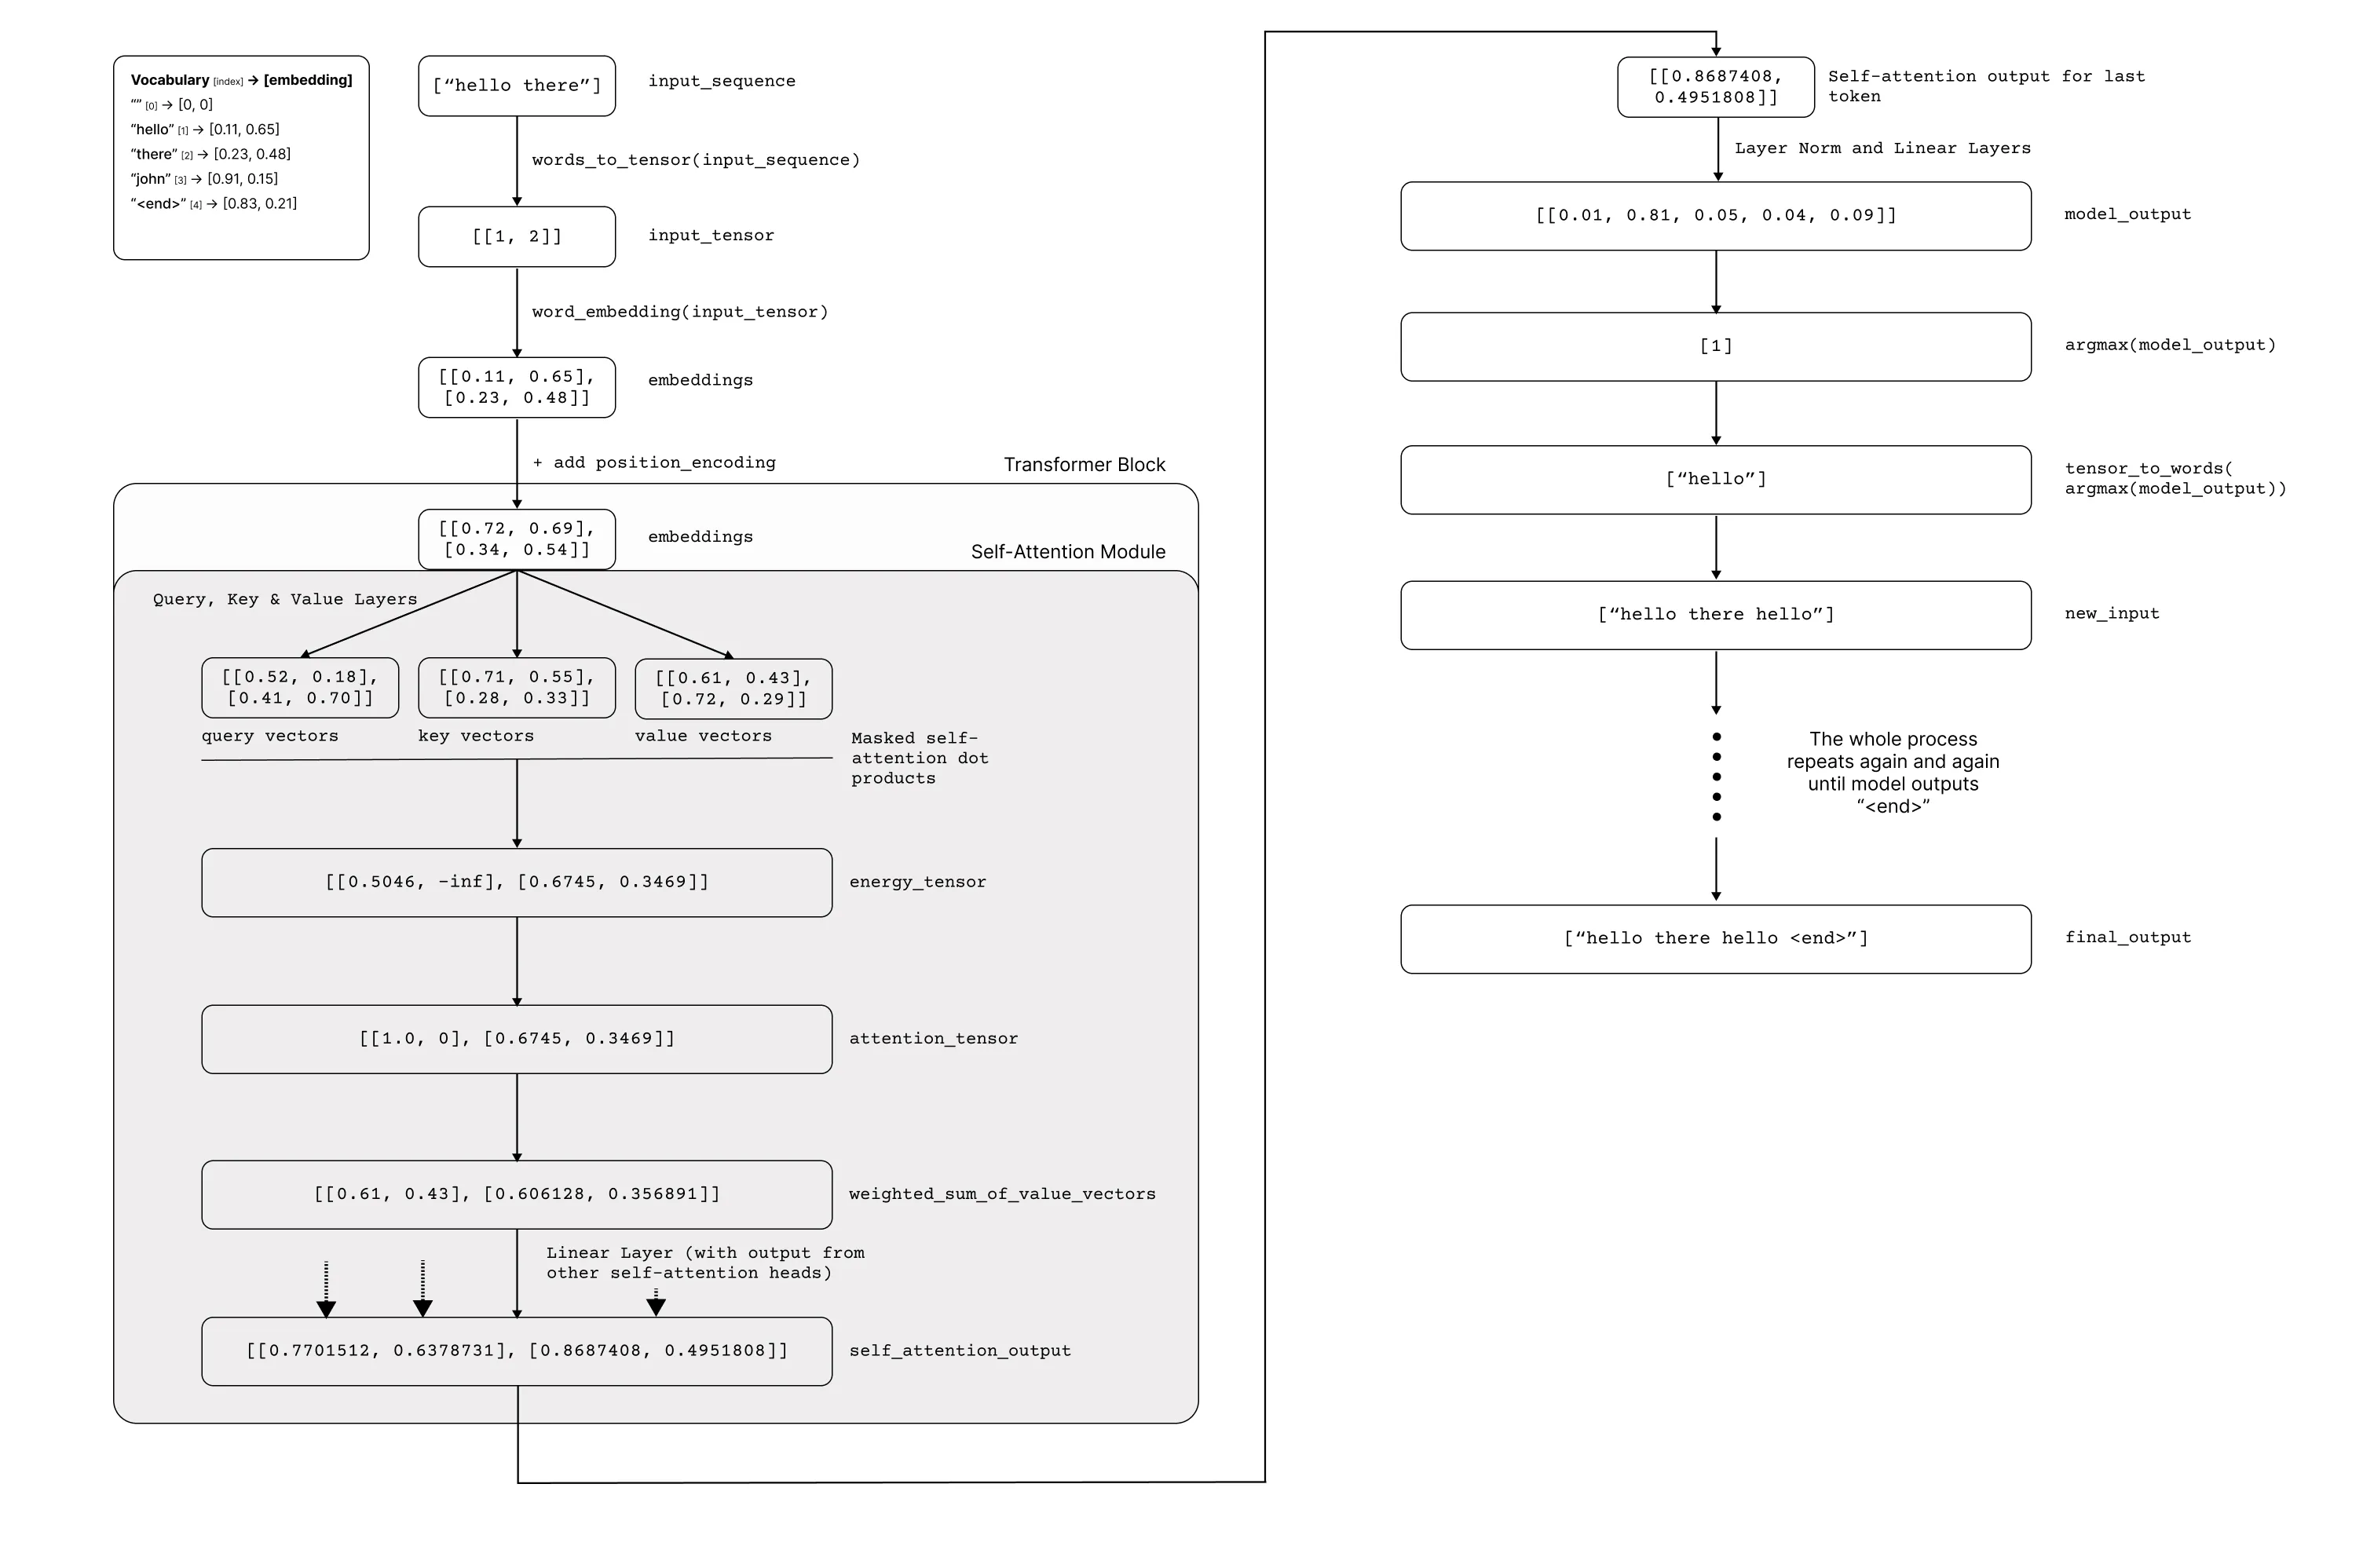

### 1.8 训练

In [ ]:
def train_recursive(model, data, targets, optimizer, criterion):
    model.train()  # 设置模型为训练状态
    optimizer.zero_grad()  # 初始化梯度
    total_loss = 0  # 初始化 total loss
    batch_size, token_count, token_count_out = data.shape[0], data.shape[1], targets.shape[1]

    # 循环所有的预训练数据
    for b in range(batch_size):
        end_encountered = False
        cur_count = 0
        # 循环预测预训练的所有 token
        while not end_encountered:
            target_vector = torch.zeros(model.vocab_size).to(data.device)  # Initialize target vector

            if cur_count != token_count_out:
                expected_next_token_idx = targets[b, cur_count]  # Get index of expected next token
                target_vector[expected_next_token_idx] = 1  # Set the corresponding element of the target vector to 1

            # Concatenate current input and output tokens and pass through model
            if cur_count > 0:
                model_input = data[b].reshape(token_count).to(data.device)
                part_of_output = targets[b, :cur_count].to(data.device)
                model_input = torch.cat((model_input, part_of_output))
            else:
                model_input = data[b]
            out = model(model_input.reshape(1, token_count + cur_count))

            # Compute loss and accumulate total loss
            loss = criterion(out, target_vector.reshape(out.shape))
            total_loss += loss
            cur_count += 1

            # Stop when the end of the sequence is reached
            if cur_count > token_count_out:
                end_encountered = True

    # Backpropagate gradients and update model parameters
    total_loss.backward()
    optimizer.step()
    return total_loss.item() / batch_size

以 `"how are you": "i am fine <end>"` 为例。

1. 首先将 `how are you` 作为模型输入
2. 模型输出下一个 token 的概率向量，和预期的 `i` 为 100%概率的预期概率向量计算loss，加入到总 loss 中。
3. 再以 `how are you i` 作为模型输入，计算下一个token 的概率向量，和预期的 `am` 为 100%概率的预期概率向量计算loss，加入到总 loss 中。
4. 循环到处理完 `<end>` 后，再循环所有的输入序列。
5. 最终使用 total_loss.backward() 计算整个模型中所有权重/参数的权重梯度（计算 dL/dw ，其中 w 是权重参数， L 是总损失）。然后使用 optimizer.step() 对所有权重参数执行与地图相反方向的权重更新（乘以学习率因子 lr）
6. 返回平均损失（仅用于记录损失观察训练过程）

实际训练时，一个批次计算完成后就进行一次梯度更新，一个epoch内有多次梯度更新。

### 1.9 训练

In [ ]:
training_data, data_words, target_words, vocabulary_words, word_to_ix, ix_to_word = get_data_and_vocab()

# 定义超参
vocab_size = len(word_to_ix)
embed_size = 512
num_layers = 4
heads = 3

# Create model, optimizer, and loss function
device = torch.device("cpu")
model = Transformer(vocab_size, embed_size, num_layers, heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

# Convert training data to tensors
data = words_to_tensor(data_words, device=device)
targets = words_to_tensor(target_words, device=device)

# Train model for 55 epochs
for epoch in range(55):
    avg_loss = train_recursive(model, data, targets, optimizer, criterion)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')


Epoch 1, Loss: 12.3547
Epoch 2, Loss: 12.3134
Epoch 3, Loss: 12.2718
Epoch 4, Loss: 12.2295
Epoch 5, Loss: 12.1844
Epoch 6, Loss: 12.1332
Epoch 7, Loss: 12.0738
Epoch 8, Loss: 12.0120
Epoch 9, Loss: 11.9469
Epoch 10, Loss: 11.8770
Epoch 11, Loss: 11.8019
Epoch 12, Loss: 11.7227
Epoch 13, Loss: 11.6423
Epoch 14, Loss: 11.5618
Epoch 15, Loss: 11.4810
Epoch 16, Loss: 11.4026
Epoch 17, Loss: 11.3278
Epoch 18, Loss: 11.2565
Epoch 19, Loss: 11.1874
Epoch 20, Loss: 11.1206
Epoch 21, Loss: 11.0561
Epoch 22, Loss: 10.9935
Epoch 23, Loss: 10.9313
Epoch 24, Loss: 10.8699
Epoch 25, Loss: 10.8090
Epoch 26, Loss: 10.7478
Epoch 27, Loss: 10.6860
Epoch 28, Loss: 10.6237
Epoch 29, Loss: 10.5616
Epoch 30, Loss: 10.4999
Epoch 31, Loss: 10.4386
Epoch 32, Loss: 10.3778
Epoch 33, Loss: 10.3176
Epoch 34, Loss: 10.2586
Epoch 35, Loss: 10.2019
Epoch 36, Loss: 10.1473
Epoch 37, Loss: 10.0954
Epoch 38, Loss: 10.0467
Epoch 39, Loss: 10.0017
Epoch 40, Loss: 9.9603
Epoch 41, Loss: 9.9225
Epoch 42, Loss: 9.8885
Epoc

可以看到模型在2-3个序列上预测比较正确，这是因为这个数据集是很难收敛的。

实际上的 GPT模型（如 LLama）其架构相似，不过增加了很多优化点，包括 RoPE 可变长的相对编码、KV Cache 缓存、更多的解码支持等。但是核心原理相同。

In [ ]:
# Perform inference on training data
input_vector = words_to_tensor(data_words, device=device)
predicted_vector = infer_recursive(model, input_vector)
predicted_words = tensor_to_words(predicted_vector)

# Print training data and model output
print("\n\n\n")
print("Training Data:")
pprint.pprint(training_data)
print("\n\n")
print("Model Inference:")
result_data = {data_words[k]: predicted_words[k] for k in range(len(predicted_words))}
pprint.pprint(result_data)

Infering sequence 0
Infering sequence 1
Infering sequence 2
Infering sequence 3
Infering sequence 4
Infering sequence 5




Training Data:
{'how are you': 'i am fine <end>',
 'how is john': 'i dont know <end>',
 'where is john': 'at home <end>',
 'who are you': 'mini gpt model <end>',
 'who is john': 'a nice person <end>',
 'who is nice': 'john <end>'}



Model Inference:
{'how are you': 'i dont <end>',
 'how is john': 'i dont know <end>',
 'where is john': 'at home <end>',
 'who are you': 'mini gpt <end>',
 'who is john': '<end>',
 'who is nice': 'person <end>'}


In [ ]:
other_inputs = ["who is you", "where is you"]
other_outputs = tensor_to_words(infer_recursive(model, words_to_tensor(other_inputs, device=device)))

pprint.pprint(other_inputs)
print("\n\n")
pprint.pprint(other_outputs)

Infering sequence 0
Infering sequence 1
['who is you', 'where is you']



['mini gpt <end>', 'home <end>']


## 二、训练一个真正的 GPT 模型

请使用 nanoGPT 库：
https://github.com/karpathy/nanoGPT/blob/master/config/train_gpt2.py

使用 8xA100 40GB 的显卡，用5天可以从头训练出一个 124M 参数的 GPT-2模型。

同时这个项目提供了在1GB 的 shakespeare 文本上的训练，可以训练出小参数模型验证。此外也支持直接加载已有的 GPT2 模型进行微调和推理。

In [ ]:
%pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [ ]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken

# -----------------------------------------------------------------------------
start = "I don't know about you, but there's only one thing I want to do after a long day of work" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 30 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

model = GPT.from_pretrained("gpt2", dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)


start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
I don't know about you, but there's only one thing I want to do after a long day of work… I want to wear my body on display to the world."

She had been back at the office for a few hours before deciding to come
---------------
